In [1]:
import pandas as pd
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
from scripts.backtesting.backtesting import Strategy, Backtest 
from scripts.backtesting.lib import resample_apply
from ta.trend import EMAIndicator
import scripts.functions as fn 


c:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www\backtest


c:\Users\lbisa\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='datetime'>

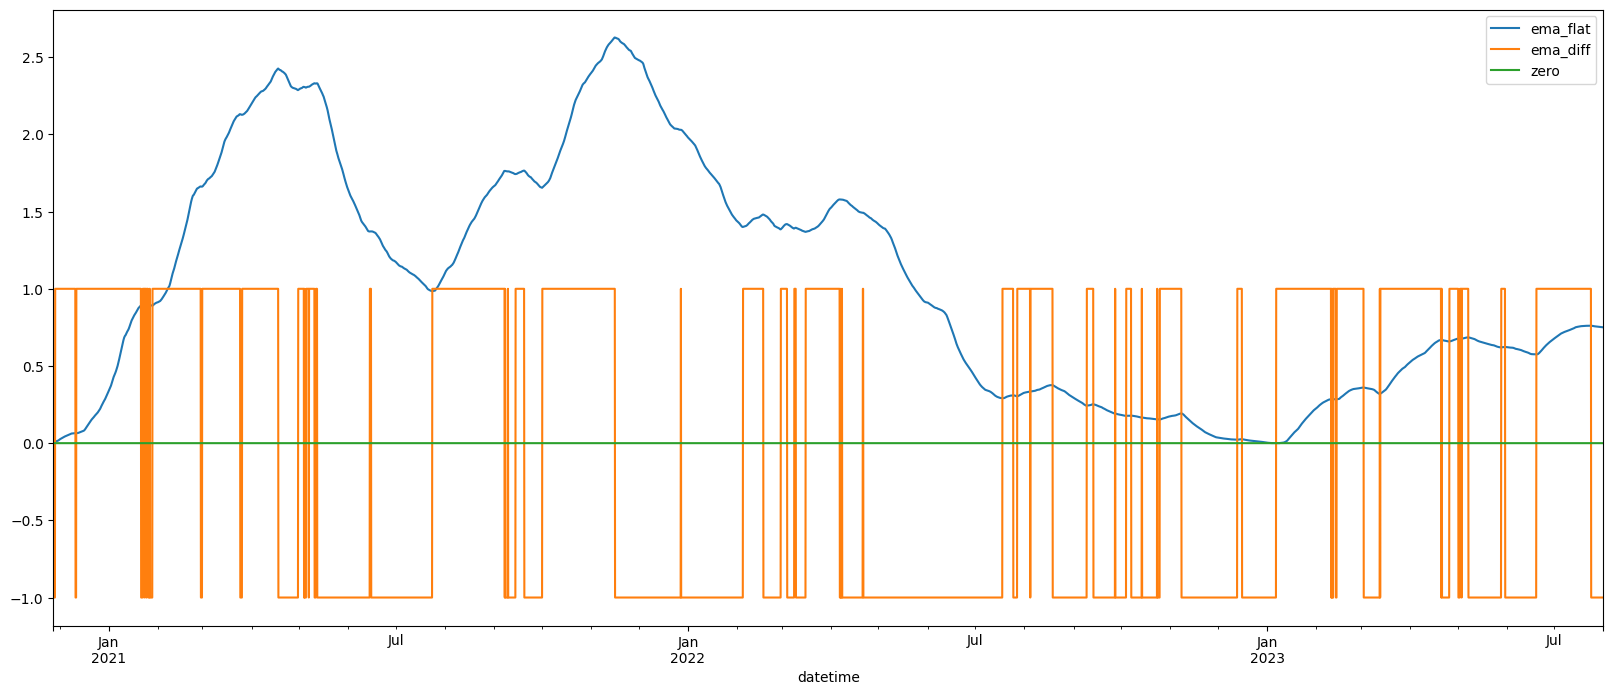

In [2]:
#klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

with open(klines_file, 'rb') as file:
    data = pickle.load(file)
    data.set_index('datetime',inplace=True)
    data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

data['ema'] = data['Close'].ewm(span=200, adjust=False).mean()

pos_1 = 0.001
pos_2 = 0.001
def calcular_derivada(row):
    global pos_1,pos_2
    val1 = 0
    val2 = ((pos_2/pos_1)-1)*100
    val3 = ((row['ema']/pos_1)-1)*100
    x = np.arange(3)  # Utilizar 3 puntos para ajustar un polinomio de grado 2
    y = np.array([val1,val2,val3])
    coeficientes = np.polyfit(x, y, 2)
    derivada = round(2 * coeficientes[0] * x[0] + coeficientes[1],2)
    pos_1 = pos_2
    pos_2 = row['ema']
    return derivada

data['ema_perc'] = ((data['ema']/data['ema'].min())-1) * 100
data['ema_pend'] = data['ema_perc'].diff(20)
data['ema_pend_p'] = data[data['ema_pend']>0.5]['ema_pend']
data['ema_pend_n'] = data[data['ema_pend']<-0.5]['ema_pend']
#data['ema_diff'] = data['ema_perc']-(data['ema_perc'].shift(1)+data['ema_perc'].shift(2))/2
data['ema_diff'] = np.where(data['ema_perc']>(data['ema_perc'].shift(2)),1,-1)

data['ema_flat'] = data['ema_perc']/100
data['zero'] = 0.0

#data[['ema_pend_p','ema_pend_n']].plot(figsize=(20,8))#,subplots=True)
data[['ema_flat','ema_diff','zero']].plot(figsize=(20,8))


In [3]:
data['ema_pend'].describe()

count    5842.000000
mean        0.253236
std         4.764800
min       -16.210968
25%        -2.389510
50%        -0.084796
75%         2.994795
max        16.019921
Name: ema_pend, dtype: float64

In [4]:
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def EMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).ewm(span=n, adjust=False).mean()

def NONE(values):
    
    return pd.Series(values)


def perc_pend(y):
    ln = len(y)
    base = y[0]
    py = (y/base)*100
    pend = fn.pendiente(py)
    return pend

def PEND(values, p):
    ema = pd.Series(values).ewm(span=p, adjust=False).mean()
    n=3
    ret = pd.Series()
    for i,v in ema.iteritems():
        if i<=n:
            ret += [0]
        else:
            y= np.array([values[i-2],values[i-1],values[i]])
            ret += [perc_pend(y)]
    return ret 
   



In [5]:


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 7
    n2 = 30
    sl = 1
    tp = 10

    orderid = 0

    buy_price = 0
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = resample_apply('D', SMA, self.data.Close, self.n1, plot=False )
        self.ema2 = resample_apply('D', SMA, self.data.Close, self.n2, plot=False )
        self.ema = self.I(NONE,self.data.ema, name='EMA')
        self.pend = self.I(NONE,self.data.ema_pend, name='EMA_PEND', overlay=False)

       
        
    def next(self):
        #chequea stop-loss, take-profit y trailing

        price = self._broker.last_price
        if self.data.ema_diff[-1] >0.25 and self._broker.position.size == 0:
            self.buy_price = price
            
            size = (self._broker._cash * 0.8) / price
            
            sl_price = None if self.sl is None else price * (1-(self.sl/100))
            tp_price = None if self.tp is None else price * (1+(self.tp/100))
            self.orderid +=1
            tag = f'OP {self.orderid}'
            self.buy(size=size,tag = tag)


        if price < (self.buy_price - (self.buy_price * (self.sl/100) )) and self._broker.position.size > 0:
            self.buy_price = 0
            self.position.close()      
        if self.data.ema_diff[-1] < -0.5 and self._broker.position.size > 0:
            self.buy_price = 0
            self.position.close()


In [6]:
#Quita las primeras 210 velas, que son agregadas al descargar datos para preveer el armado de indicadores 
#y que la estrategia inicie con los indicadores previamente armados 


class Bot(Backtest):
    
    def __init__(self,data,strategy):
        #Ajusa el precio a valores entre referenciales porque Backtesting.py limita los decimales en el size para las compras
        cash = 100000

        super().__init__(data, strategy, cash=cash, commission=.002, trade_on_close=False)
    
bot = Bot(data,SmaCross)
stats = bot.run()

bot.plot(open_browser=True, plot_trades=False, resample=True, superimpose='1W')


GridPlot(id='p1562', ...)

In [7]:

print(f'Periodo: {stats.Start} al {stats.End}')
print(f'Duracion: {stats.Duration}')
print('Return (Ann.) [%]',stats['Return (Ann.) [%]'])
print('Max. Drawdown [%]',stats['Max. Drawdown [%]'])
print('# Trades',stats['# Trades'])
#stats


Periodo: 2020-11-27 01:00:00 al 2023-07-31 21:00:00
Duracion: 976 days 20:00:00
Return (Ann.) [%] 37.280778284566374
Max. Drawdown [%] -27.921025571892667
# Trades 76


In [8]:
#bot.plot(open_browser=True,resample=True,superimpose='1D')
equity = stats._equity_curve.copy()
# 
print(equity.head())
print(data[209:].head())

                       Equity  DrawdownPct DrawdownDuration
2020-11-27 01:00:00  100000.0          0.0              NaT
2020-11-27 05:00:00  100000.0          0.0              NaT
2020-11-27 09:00:00  100000.0          0.0              NaT
2020-11-27 13:00:00  100000.0          0.0              NaT
2020-11-27 17:00:00  100000.0          0.0              NaT
                         Open      High       Low     Close        Volume  \
2020-12-31 21:00:00  28923.63  29470.00  28690.17  29278.40  11560.456553   
2021-01-01 01:00:00  29278.41  29395.00  28806.54  29092.83   7308.910274   
2021-01-01 05:00:00  29092.84  29402.57  28872.24  29313.49   8283.705319   
2021-01-01 09:00:00  29313.49  29600.00  29030.14  29188.67  11794.949515   
2021-01-01 13:00:00  29188.67  29360.00  28624.57  29029.04   9850.965345   

                              ema   ema_perc  ema_pend  ema_pend_p  \
2020-12-31 21:00:00  22596.964719  33.705263  7.199851    7.199851   
2021-01-01 01:00:00  22661.600195  34

<Axes: >

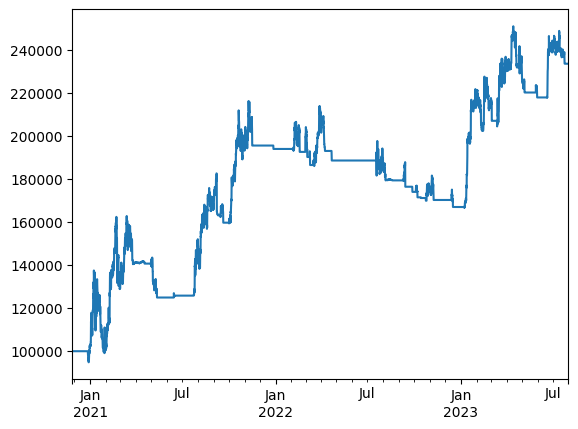

In [9]:
equity['Equity'].plot()


